# AIART #2 - LEARNING REPRESENTATIONS
***

### -- [0.0] -- SETUP

HeadLine Image  

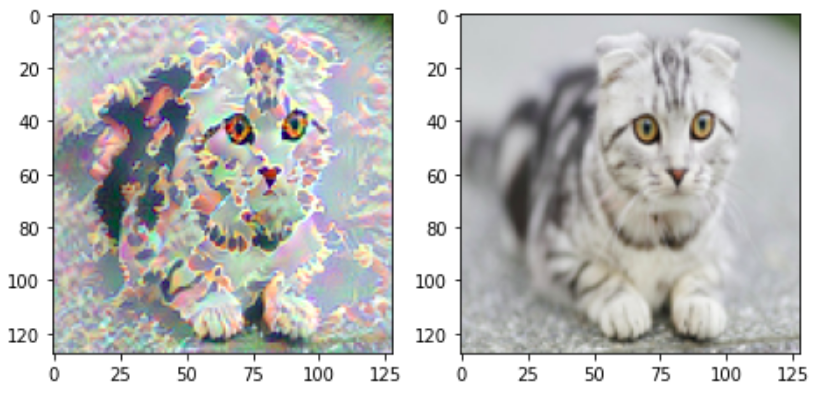

Last week we saw how we can optimise a set of parameters of some arbitrary  
function to (hopefully) reduce some loss. In the process we got familiar with  
some PyTorch building blocks, and by the end we'd even made some pretty pictures  
by treating CLIP as a magical balck box. 

One thing we didn't speak about at all is neural networks. Today we fix that :)  

- We'll look at how to create simple NNs in PyTorch, 
- and then take a quick look at some of the improvements that have made deep  
learning models so good in recent years. 

We'll see that a key feature that makes deep learning models so useful is that  
they are able to learn good representations.

By taking advantage of some of the inner representations learnt by a pre-trained  
convolutional neural network, we'll optimize an image to have the 'style' of one  
picture and the 'content' of another (style transfer). 

These sorts of network-based loss functions can be useful in all sorts of contexts.

Moving on from there, we'll shift gear and ask a new question:  
- how can we learn a representation that is useful for generating images 
(rather than simply classifying them)?  
- And how do we extend this into a model that can generate novel yet plausible  
new images based on a training set? 

This will lay the groundwork for GANs which we'll meet in lesson 3.

Finally, as a bonus at the end we'll take one of our toy generative models and  
mash it together with CLIP to make some weird pictures :)

Last week's lesson: 

- https://colab.research.google.com/drive/1pp8hS5C6RTMpOLBJMwnx3d7JjicqgJKx?usp=sharing

#### Initializing NoteBook Environment

In [93]:
# imports for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from typing import Union

# Set the device to use for computations (CUDA if available, otherwise CPU)
def set_device():
    device_type: Union[str, torch.device] = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device_type)
    print(f'Using device: {device}')
    return device

device = set_device()

# imports data handling
from PIL import Image
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import random

# import notebook libs
from tqdm.notebook import tqdm

# initialize notebook style
import matplotlib.pyplot as mpl

def set_notebook_plot_style():
    mpl.rcParams['figure.figsize'] = (10, 6)
    mpl.rcParams['figure.dpi'] = 120
    mpl.rcParams['figure.facecolor'] = 'none'
    mpl.rcParams['axes.titlecolor'] = 'lightgrey'
    mpl.rcParams['axes.edgecolor'] = 'grey'
    mpl.rcParams['xtick.color'] = 'lightgrey'
    mpl.rcParams['ytick.color'] = 'lightgrey'
    mpl.rcParams['axes.labelcolor'] = (1, 1, 1, 0.5)

set_notebook_plot_style()

# iframe width and height for embedding videos 
iframe_width = 560
iframe_height = 315

Using device: cpu


#### Setup and Imports

In [53]:
# Downloading MNIST Dataset
import tarfile, requests, os

fname = 'MNIST.tar.gz'
name = 'mnist'
url = 'https://osf.io/y2fj6/download'

if os.path.exists(fname):
    print('MNIST.tar.gz available for extraction')
else:
    print('Downloading MNIST dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
        fh.write(r.content)
    print('Downloading MNIST completed...')

if os.path.exists(name):
    print('MNIST dataset already extracted')
else:
    print('MNIST dataset extracting')
    with tarfile.open(fname) as tar:
        tar.extractall(name)
        os.remove(fname)

MNIST.tar.gz available for extraction
MNIST dataset already extracted


#### Lesson 2 Video

In [17]:
#@title Lesson 2 Video
# The `#@title` syntax is specific to Google Colaboratory (Colab) notebooks and 
# is used to add a title to a code cell. Colab has some custom features and 
# extensions that are not available in the standard Jupyter Notebook environment 
# or in other Jupyter interfaces like the one in Visual Studio Code (VSCode).

url = "https://www.youtube.com/embed/peTkMmRrxPg"
iframe = ipd.IFrame(url, width=iframe_width, height=iframe_height)
ipd.display(iframe)

### -- [1.0] -- PYTORCH FOR ANNs
***

PyTorch is designed to make building and training neural networks as easy as  
possible. This means there are lots of built-in classes and methods that will  
make our lives easier :)

- Here's a video that gives a good overview of some of these classes which we'll  
going to use:

In [18]:
url = 'https://www.youtube.com/embed/jzTbQACq7KE'
iframe = ipd.IFrame(url, width=iframe_width, height=iframe_height)
ipd.display(iframe)

#### -- [1.1] -- SIMPLE NEURAL NETWORK

Let's start by making a smallish network to solve a small (contrived) problem.  
We'll generate some data, and as in the first lesson we'd like our network to  
learn the relationship between our input data (x) and output data (y).

Generate Data (Inputs and Targets)

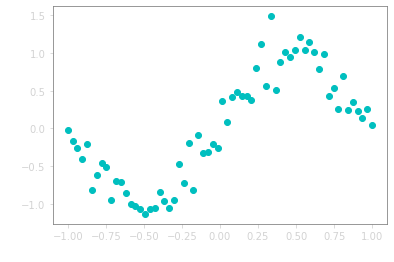

In [34]:
# Generating synthetic data (inputs and targets)
n_samples = 64

# Creating a 1D tensor of equally spaced points from -1 to 1, and reshaping it 
# to a 2D tensor with shape (n_samples, 1)
# torch.Size([64]) => torch.Size([64, 1])
# view vs reshape :
# - Use `reshape` when you need a more flexible approach that works with both 
# contiguous and non-contiguous tensors
# - and you don't mind the possibility of creating a NEW data copy
# **Non-contiguous tensors** have their elements stored in a non-continuous or 
# fragmented manner in memory. This can happen when you perform certain 
# operations on a tensor, like : 
# - slicing, 
# - transposing 
# - reshaping 
#  that change the logical ORDERING of the elements WITHOUT changing their 
# actual MEMORY layout. 
# Non-contiguous tensors may have a less efficient memory access pattern, 
# which can lead to slower performance in certain operations.
inputs = torch.linspace(-1.0, 1.0, n_samples).view(n_samples, 1)
# Generating random noise with the same shape as inputs and scaling it by 0.2 
# to decrease its magnitude
# audit-ok 🔎 : I still don't understand why we scale by 0.2
noise = torch.randn(n_samples, 1) * 0.2

# Creating target values as a sine wave with a frequency of 1 and a phase of pi
# - Multiplying by pi results in a full sine wave cycle over the range [-1, 1]
# - Adding the noise to the targets to make the data more realistic
targets = torch.sin(3.14 * inputs) + noise

plt.scatter(inputs, targets, c='c')
plt.xlabel('x (inputs)')
plt.ylabel('y (targets)')
plt.show()


Here's how we can make a neural network, leaning on PyTorch's handy functions:

In [91]:
class WideNet(nn.Module):
    def __init__(self, n_cells=512): # Initialize our network
        'a wide neural network with a single hidden layer'
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, n_cells), # one input, n_cells output (default 512)
            nn.Tanh(), # one of many non-linear activation functions
            nn.Linear(n_cells, 1) # n_cells input, one output
        )

    def forward(self, x):
        'forward pass of the wide neural network'
        return self.layers(x)

We're inheriting from the `nn.Module class`, which gives us some bonus features.  
For example : 
- instead of directly calling the `forward` method (which passes the data through  
the different layers) 
- we can just create our network and call it like a function:

In [92]:
wn = WideNet()
print(f'inputs.shape {inputs.shape}')
out = wn(inputs) # passes our inputs to the forward method defined above
print(f'out.shape {out.shape}')
print(f'\nPytorch summary of wn :')
wn? #type: ignore

inputs.shape torch.Size([64, 1])
out.shape torch.Size([64, 1])

Pytorch summary of wn :


Signature:       wn(*input, **kwargs)
Type:            WideNet
String form:    
WideNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)
Docstring:       <no docstring>
Class docstring:
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth

Time for our training loop - compare this with the optimization loop we saw last  
week (spoiler: they're the same!).  
We're optimizing the parameters of our neural network - all the weights and  
biases in the different layers.

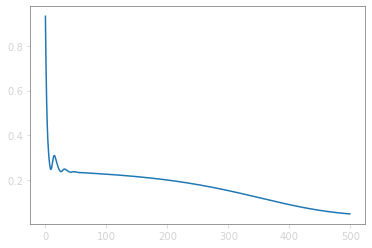

In [108]:
# Create our nueral network model architecture
wide_net = WideNet()

# Create our loss function
loss_function = nn.MSELoss() # Mean Squared Error

# Stochastic gradient descent optimizer
# Adam is SGD variant : Adaptive Moment Estimation with following key features :
# - dynamically adapts learning rate during training 
# - by computing an exponential moving average of the gradient and the squared 
# gradient
optimizer = torch.optim.Adam(wide_net.parameters(), lr=1e-3) 

# Training loop
losses = [] # keeping record of loss
for i in range(500): #500 epochs of training
    optimizer.zero_grad() # zero the gradients
    predictions = wide_net(inputs) # compute prediction (forward pass)
    loss = loss_function(predictions, targets) # compute loss
    loss.backward() # compute gradients (backward pass)
    optimizer.step() # update model parameters

    # storing our loss for later viewing
    # .detach() to remove it from the computational graph else :
    # - loss value is still a Tensor that is tied to the graph
    # - and will accumulate gradients in the backward pass
    # makes it a simple floating point value (a "leaf Tensor") instead of a 
    # Tensor connected to the graph
    # Benefits :
    # - prevents accidental gradient computation
    # - saves memory
    # - smaller serialization size
    # @audit-ok 🔎 : Are there any DOWNSIDES to using .detach() ?
    losses.append(loss.detach().item())

# Plot losses over time
plt.plot(losses)

**THINK/DISCUSS:** Go line-by-line through the code above - does it make sense?

Notice we don't have to set `requires_grad manually` on any of the parameters,  
since the learnable parameters in each layer are grouped automatically by  
`wide_net.parameters()` (inspect that and see what it contains).

`Plot` the `predictions` vs the actual `data` to `check` if our `network` as indeed  
`learnt the relationship` that we wanted it to learn

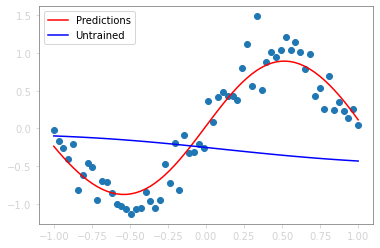

In [109]:
# plot data and predictions
plt.scatter(inputs, targets)
plt.plot(inputs, wide_net(inputs).detach(), c='red', label='Predictions')

# create a new untrained wide net and plot those predictions for comparison
new_wn = WideNet()
plt.plot(inputs, new_wn(inputs).detach(), c='blue', label='Untrained')

plt.legend()
plt.show()

**CHALLENGE:** Create a nueral network with two hidden layers and train it on this same task ...

In [88]:
# @todo : Update nn.Module nn.Sequential to have more than the one hidden layer
'''
class WideNet(nn.Module):
    def __init__(self, n_cells=512): # Initialize our network
        'a wide neural network with a single hidden layer'
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, n_cells), # one input, n_cells output (default 512)
            nn.Tanh(), # one of many non-linear activation functions
            nn.Linear(n_cells, 1) # n_cells input, one output
        )
'''

Init signature: WideNet(n_cells=512)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:ivar training: Boolean represents whether this module is in training or
                evaluation mode.

### -- [2.0] -- A LIGHTNING OVERVIEW OF CONVNETS
***

So-called 'dense' networks are useful in some cases, but we need to be mindful  
of the number of parameters required to solve certain types of problems.  

For example, consider the case of image recognition - our inputs consist of  
thousands of individual pixel values. A dense network that could take in 500px  
images and then run them through many hidden layers ends up with millions or  
billions of parameters, which can make training tricky.

In addition, each pixel feeds into a different part of the network. When we look  
at how the vision system works in the brain, or just think about what we'd want  
in a computer vision system, we'll start to hit requirements that might not be  
easy to satisfy with a simple MLP network.  

Fortunately, we have some tricks to imporve things! Here's another video that  
takes us through a key idea in deep learning for images:  

- CNNs

Here's another video from the (free and I think CC-licenced) neuromatch course  
that gives a little more background:

Representations & Visual Processing (NMA video)

In [111]:
url = 'https://www.youtube.com/embed/AXO-iflKa58'
iframe = ipd.IFrame(url, width=iframe_width, height=iframe_height)

ipd.display(iframe)

The following interactive website is a great way to get an intuition for both  
how convolution works. You can see each learned filter and the corresponding  
output.  

It also shows a second key idea: pooling. By 'downsampling' the outputs of  
successinve convolution layers we end up with fewer and fewer activations, each  
representing more and more of the input image.  

Play around a bit until you're sort of happy with the basic concepts (see the  
video for more discussion and explanations) and then move on to the next section,  
where we'll build our own very similar network.

In [115]:
url = 'https://www.cs.cmu.edu/~aharley/vis/conv/'

iframe = ipd.IFrame(url, width=iframe_width*1.5, height=iframe_height*1.5)
ipd.display(iframe)

For more on what convolution is, how the different hyperparameters (padding,  
stride etc) do and a general overview of CNNs, see : 
 https://poloclub.github.io/cnn-explainer/

#### -- [2.1] -- THE DATASET

We'll use the classic `MNIST dataset` (as shown in the video and examples above).  
But these same ideas apply to more complex image recognition

Loading the Data

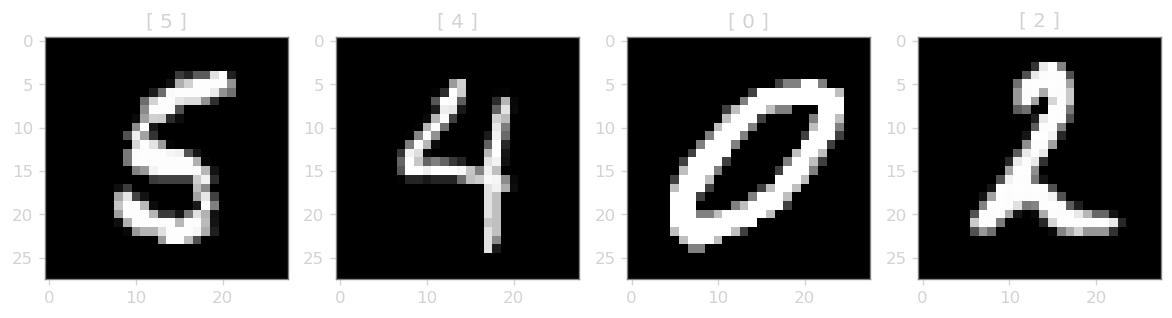

In [14]:
mnist = datasets.MNIST('./mnist/',
                       train=True,
                       transform=transforms.ToTensor(),
                       download=False)

mnist_val = datasets.MNIST('./mnist/',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

# channel = 1, height = 28, width = 28
data_shape = (1,28,28)

# Plot a few samples
fig, axs = plt.subplots(1,4, figsize=(12,4))
for i in range(4):
    im, label = mnist[random.randint(0, len(mnist))]
    axs[i].imshow(im.squeeze(), cmap='gray')
    axs[i].set_title(f'[ {label} ]')

#### -- [2.2] -- DEFINING OUR NETWORK

The convolution operation is handled by the `nn.Conv2d` layer

In [135]:
??nn.Conv2d # type: ignore

Init signature:
nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:

Let's use nn.Conv2D to convolve this image with some random kernels:

In [149]:
conv_test = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, padding=0)
image = mnist[0][0].unsqueeze(0) # unsqueeze to `batch of size of 1`
# one channel greyscale image
print(f'-- [Input] -- \nimage.shape {image.shape}')
# torch.Size([1, 28, 28]) (mnist) =>  torch.Size([1, 1, 28, 28]) (image)
print(f'# unsqueezed(0) from mnist[0][0].shape {mnist[0][0].shape}\n')
# 12 output channels (from 12 kernels)
# @audit-ok 🔎 : Explain why the final shape is smaller, how does padding work ?
print(f'-- [Output] -- \nconv_test(image).shape {conv_test(image).shape}')

-- [Input] -- 
image.shape torch.Size([1, 1, 28, 28])
# unsqueezed(0) from mnist[0][0].shape torch.Size([1, 28, 28])

-- [Output] -- 
conv_test(image).shape torch.Size([1, 12, 24, 24])


Note the final shape is slightly smaller - how does padding change this?  
Does the output shape make sense?  
This layer has some trainable parameters: the kernels. Let's check these out:

In [144]:
conv_test.weight.shape # 12 filters of size 5x5

torch.Size([12, 1, 5, 5])

-- Network Definition --

Here's a network that uses these layers (along with `nn.MaxPool2d` for the  
downsampling/pooling).  

We could use `nn.Sequential` as in the previous example, but I'd like to show  
another common style here.  

We define all the layers we'll need in __init__ but only in the forward() method  
do we actually specify how that data should flow through the network.

**`{class}`** -- [MiniCNN] --

In [46]:
class MiniCNN(nn.Module):
    def __init__(self):
        '[init] cnn with maxpool2d for downsampling/pooling'
        super(MiniCNN, self).__init__()
        # @audit 🛑 : Explain why commenting out explicit args improved perf 10x?
        # if not the explicit args listed, what is the args order?
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3) # @success
        # self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv1 = nn.Conv2d(1, 32, 3) # @success
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10) # 10 output classes (supports 0-9 digits)
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        '[forward] pass of the cnn'
        x = self.conv1(x) # @success
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1) # success
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

#### -- [2.3] -- TRAINING THE LOOP
![training](https://media3.giphy.com/media/xT0xekSmUwcoD6SxzO/giphy.gif)

Here's a training loop that should now be getting quite familiar. A few noteworthy  
things:  

- We can't push all the images through in one go, so within each `epoch`  
(i.e. each full psas through the data) we do multiple `batches`. 

- This is when `Gradient Descent` becomes `Stochastic Gradient Descent` or  
'Mini-batch GD' depending on who you're talking to. PyTorch does the batching  
for us via something called a `DataLoader`.  

- We'd like to train on the GPU, so we need to make sure both the model and the  
data are on the right device with `.to(device)` (device is defined earlier).  

- We're using a loss function that is good for classification tasks:  
`nn.CrossEntropyLoss()`. Accuracy has 'steps' and so it makes differentiation  
tricky. By treating the outputs of the network as probabilities we can see how  
confident it is that something is in a specific class while keeping everything  
continuous and differentiable. Don't worry too much about this :)

In [47]:
#Data in dataloader
train_loader = DataLoader(mnist, batch_size=16, shuffle=True)

# Setup model, loss function and optimizer
model = MiniCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training Loop
for epoch in range(2):
    print(f'[Epoch] {epoch}')
    for data, target in tqdm(train_loader, unit='batch'):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

[Epoch] 0


  0%|          | 0/3750 [00:00<?, ?batch/s]

[Epoch] 1


  0%|          | 0/3750 [00:00<?, ?batch/s]

#### -- [2.4] -- EVALUATION - How well does it do?
![testing](https://media3.giphy.com/media/JRPftUYuIRw3axuh5y/giphy-downsized-large.gif)

In [49]:
# Testing
correct = 0
total = len(mnist_val)
test_loader = DataLoader(mnist_val, batch_size=16, shuffle=True)

with torch.no_grad():
    # Iterate through test minibatches
    for data, labels in tqdm(test_loader):
        data, labs = data.to(device), labels.to(device) # @audit 🛑 : labs or labels?
        y = model(data) # forward pass
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum(predictions == labs).float()

print(f'[Test Accuracy] {correct/total * 100:.2f}')

  0%|          | 0/625 [00:00<?, ?it/s]

[Test Accuracy] 96.37


**Exercise:** Go wild and try to improve the training results, tweak the :  
- architecture
- hyperparameters
- training time
- optimizer

Phew! Welcome to deep learning :)  

We're learning just enough to move on and make art, but these are some big topics  
and we're barely scratching the surface.  

If you're interested in more of the theory or implementing some of these ideas  
from scratch, you might like to check out the content at :  
- https://deeplearning.neuromatch.io/  

or one of the many deep learning courses on various MOOC platforms.  

If you'd like a more top-down approach to doing practical deep learning realy  
well, I can't recommend the fastai course highly enough.

For now, let's look at a slightly more complex neural network that has been  
trained to classify many different classes of images. Specifically, we'll see if  
we can use the internal representations it has developed to do something  
artistic :)

### -- [3.0] -- STYLE TRANSFER
***

![style](https://media.giphy.com/media/28goxl0nrEjmiJEuHI/giphy.gif)

Remember how we said that : 

- early layers in a network tend to learn simpler features like colour and texture  
- while later layers capture more complex shapes?  

We're going to take advantage of this to do a little bit of magic.  

We'll take two images, a `content image` and a `style image`. Then we'll feed both  
through a network and record the activations at various layers.

Now we can start with noise or begin with the content image, and set it up as a  
tensor to be optimised. Then, we start tweaking it such that when we feed it  
through the same big network :  
- the activations in the `early layers` ('style') are similar to those of the  
`style` image 
- while the activations of `later layers`, more linked to `overall structure` and  
shapes ('content') match the `content` image.  

In effect we're trying to minimise some `combination of two loss functions`, a  
`style loss` and a `content loss`.

First, let's look at a pretrained network and pull some features from it:

#### -- [3.1] -- EXTRACTING REPRESENTATIONS FROM PRETRAINED MODELS

`VGG16` was a fairly popular CNN that improved upon the famous `AlexNet`   
architecture. 

It has since been supeceeded by more complex networks but it still works great  
for our purposes. 

The architecture is something like the following (source [link text](https://https://neurohive.io/en/popular-networks/vgg16/)):

![architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

Load our pretrained `VGG16` model:

In [54]:
from torchvision.models import vgg16

vgg = vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/mton/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

**`{class}`** -- [VGGFeatureExtractor] --

Code adapted from here ^ to create a feature extractor that will record the  
outputs of neurons in specified layers :  
- Ref: https://www.kaggle.com/danmoller/easy-style-transfer-with-pytorch

In [95]:
class VGGFeatureExtractor(nn.Module):
    def __init__(self, vggModel, layerIndices):
        ''' 
        Ref: https://www.kaggle.com/danmoller/easy-style-transfer-with-pytorch
        Model set to untrainable : all parameters.requires_grad = False
        '''
        super(VGGFeatureExtractor, self).__init__()
        self.features = vggModel.features

        # desired layers
        self.layerIndices = layerIndices
        self.outputCount = len(layerIndices)

        # making this model's parameters untrainable
        for param in self.parameters():
            param.requires_grad = False

    # @audit 🛑 : Explain when forward is called?
    def forward(self, x):
        outputs = list() # outputs from the selected layers

        # for each layer in the vgg model
        for i, layer in enumerate(self.features.children()):
            x = layer(x) # apply the layer @audit 🛑 : is this a forward pass?

            # if this layer is the desired layer, store its outputs
            if i in self.layerIndices:
                outputs.append(x)

                #check if we got all the desired layers
                if i == self.layerIndices[-1]:
                    break # early exit if this is the last desired layer
        return outputs


**Content Image**
- To test it out, let's download a couple of images which we'll later use to try  
style transfer

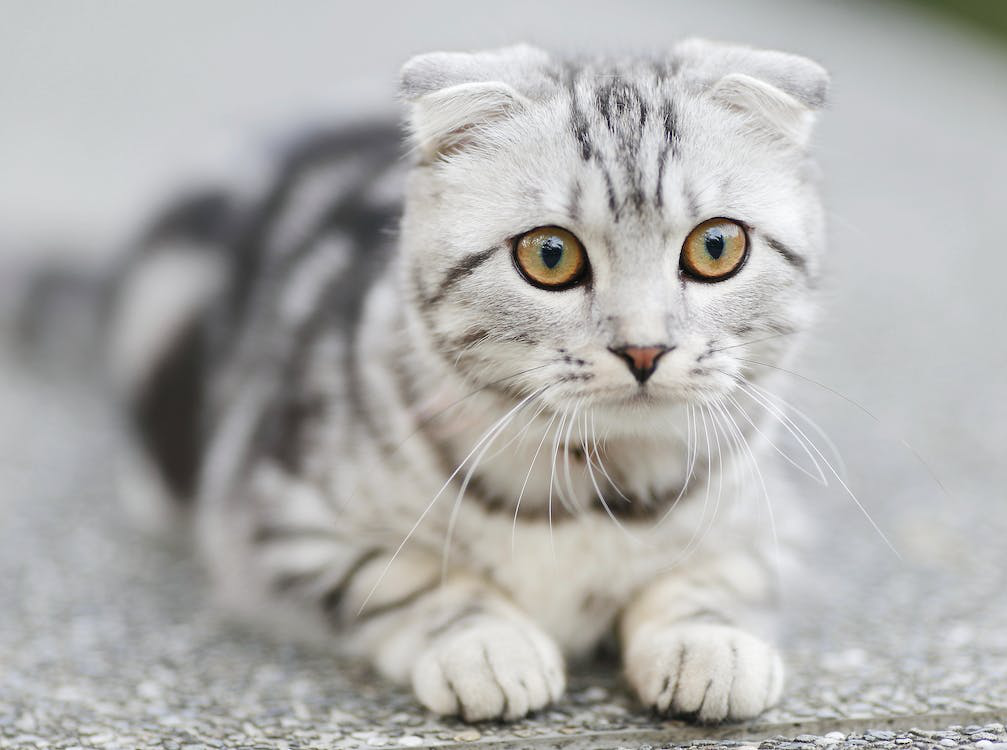

In [87]:
import requests

url = 'https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'
img_content_fname = 'cat.jpeg'
r = requests.get(url, allow_redirects=True)
open(img_content_fname, 'wb').write(r.content)
content_image = Image.open(img_content_fname)
content_image

**Style Image**

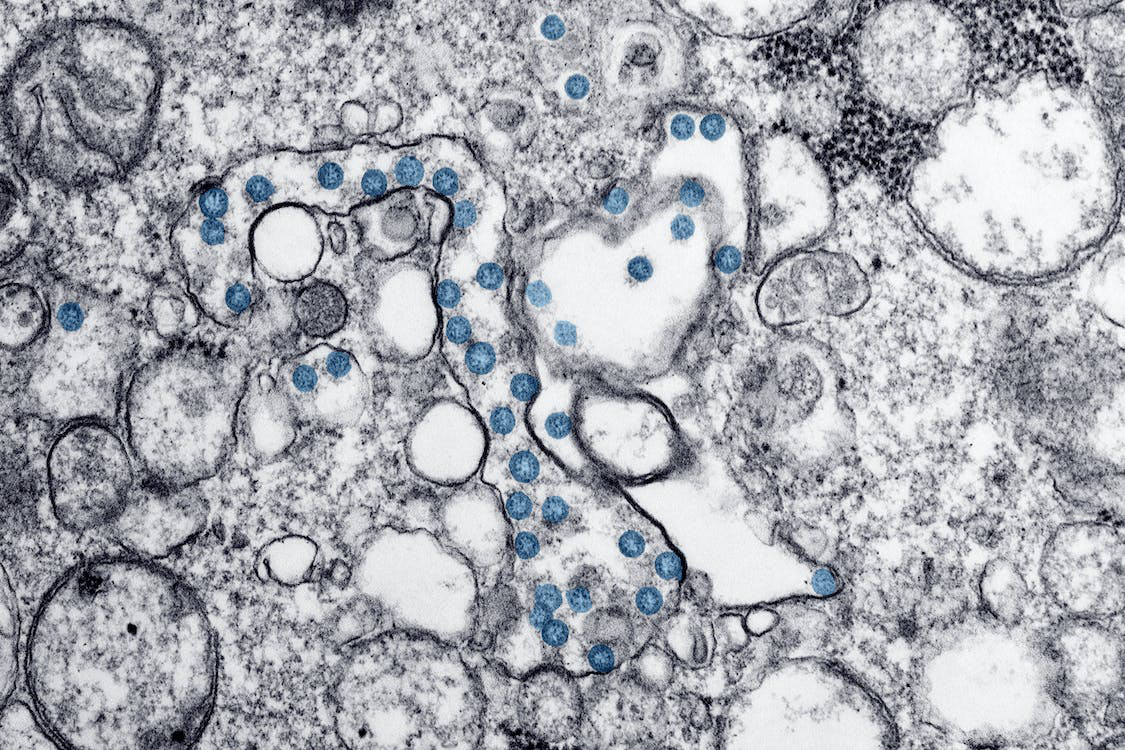

In [98]:
import requests

url = "https://images.pexels.com/photos/3992944/pexels-photo-3992944.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
img_style_fname = 'style.jpeg'
r = requests.get(url, allow_redirects=True)
open(img_style_fname, 'wb').write(r.content)
style_image = Image.open(img_style_fname)
style_image

PIL Image to Torch Tensor `function()`

In [90]:
def pil_to_torch(img):
    'convenience function to convert PIL Image to Torch Tensor'
    # convert image to numpy array
    # normalize to [0,1] range for image data by dividing by 255
    # permute channels from (H,W,C) to (C,H,W) for Pytorch CNNs
    # unsqueeze to add an "extra" batch dimension
    return torch.tensor(np.array(img)/255.0, dtype=torch.float).permute(2,0,1).unsqueeze(0)

Extracting the activations from a few later layers to serve as our content  
features:

In [96]:
content_img_tensor = pil_to_torch(content_image)
contentExtractor = VGGFeatureExtractor(vgg, [15,19]) # @audit 🛑 : Explain why 15,19?
target_content_features = contentExtractor(content_img_tensor)

# View the shapes of the extracted features (one for each tensor layer)
[t.shape for t in target_content_features]

[torch.Size([1, 256, 187, 251]), torch.Size([1, 512, 93, 125])]

### -- [CONCLUSION] --
***

##### Explain like I’m 11 what `loss function` and `optimizers` are :
***

ANSWER :

- `Loss function` = `Measures` how bad the model is 
- `Optimizer` = Tries to make the model `less bad by updating` it accordingly! 

Here is a simple explanation of loss functions and optimizers in machine learning:

Loss function: This measures how bad the model's predictions are compared to the actual observations. It basically tells the model "how wrong you are". We want to minimize the loss, so the model gets closer and closer to making perfect predictions.

Some common loss functions are:

- Mean Squared Error (MSE): Takes the average of the squares of the errors.
- Cross Entropy: Measures the "surprise" of the predictions. Useful for classification.
- Huber: Combines the properties of MSE and Mean Absolute Error. Less sensitive to outliers.

Optimizer: This is the algorithm that makes updates to the model to minimize the loss function. It "optimizes" the model's parameters to make its predictions more accurate.

Common optimizers are:

- Gradient Descent: Updates parameters by moving in the opposite direction of the gradient (slope) of the loss function. 
- Adam: An adaptive learning rate optimizer, pretty popular. 
- RMSprop: Adapts the learning rate based on a moving average of the magnitudes of the gradients. 
- Adadelta: Adapts the learning rate based on a moving average of the magnitudes of the updates in a time window.




##### Explain like I’m 11 what is `Cross Entropy Loss` :
***

ANSWER : Cross Entropy Loss explained like you're 11:

'Cross Entropy Loss' 'measures' how unlikely the model's 'predictions' are compared to  
the 'actual labels'. It's a way to 'quantify' how 'surprised' the model is when it  
sees the 'correct answers'.

We use 'Cross Entropy Loss' for classification problems (when the labels are  
categories, like "cat" or "dog"). It 'measures' how 'incorrectly' the model  
'classifies examples'.

Here's how it works:  

1. The model makes a prediction, saying "I think the probability of this being a  
cat is 70%". 
2. The actual label says "This is actually a cat".  
3. We calculate the "surprise" of the model using the formula for Cross Entropy  
Loss. It will be low if the model was confident it was a cat, and high if the  
model was very wrong and thought it was unlikely to be a cat.  
4. We add up all the individual "surprises" to get the total Cross Entropy Loss  
for the model on the full dataset.  
5. Then we use an optimizer to update the model and minimize the loss, so it   
gets less surprised and its predictions become more accurate!  

So in the end, Cross Entropy Loss quantifies how unpredictable the model's  
predictions are compared to the correct answers in the data. By minimizing it,  
we make the model's predictions as accurate as possible.

##### Explain the `tradeoff` for downloading images between :  

- `requests`  
- `!curl`  

***

ANSWER : There are a few main tradeoffs to consider between using requests and  
!curl to download an image in Jupyter:

1. Ease of use - requests typically has a simpler, more "Pythonic" syntax for  
downloads. curl commands, while very powerful, involve more low-level options  
and syntax. So requests may be easier for beginners.  
2. Capabilities - `curl` supports many advanced features that requests does not :
- `resuming downloads`,  
- `FTP`,  
- `file uploading`,  
- `proxies`, and much more.  
So for very `complex downloads, curl may be better`.
3. `Dependencies` - requests relies on having the requests library installed,  
which adds a dependency to your environment. curl is a system command that  
typically comes pre-installed. So `curl avoids adding more dependencies`.
4. Access - By default, Jupyter Notebooks run code in a sandbox and do not have  
access to system commands or the filesystem. So curl will not work in notebooks  
by default. requests does work since it is a Python library. To use curl, you  
need to enable a "magic" to give the notebook temporary access. 
5. Integration - requests plays nicer with the Python/Jupyter ecosystem.  
Downloaded images or files can be easily manipulated using Python libraries  
after downloading. curl just gives you the raw file. 
6. Speed - curl can be faster for some types of downloads, especially larger  
files or connections with slow latency. requests is typically fast enough for  
most common use cases though.

So in summary, some main tradeoffs to consider are:  

- Ease of use vs power/flexibility  
- Adding dependencies vs using pre-installed system tools  
- Access and integrations in the notebook environment  
- Raw speed of downloading  

For most Jupyter notebook usage, requests is likely the easiest and most  
integrated approach. But for very advanced or niche downloading needs, curl  
still has its place.